Rastrigin synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 872 kB 52.0 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=5b550b72843864df12c709f85b1d272a3d808b989cb56b8cc4ccc22a74f466b5
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=551efac22bcc909bc66022a6aedb6e4d139943e7030208a1f49970d80f534c3d
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Rastrigin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Rastrigin':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -5.12 
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 19.908403246996286	 -2.8284275424952745
2  	 [4.59394822 5.12      ]	 68.33684417028886	 19.908403246996286	 -2.828427485390853
3  	 [-5.12  5.12]	 57.849427451571785	 19.908403246996286	 -2.828410465271639
4  	 [ 4.14505747 -0.05925563]	 21.743915339816308	 19.908403246996286	 -2.8283186860367358
5  	 [ 0.9002181  -3.68905846]	 30.05751314896067	 19.908403246996286	 -2.8253475660016103
6  	 [0.71475953 5.12      ]	 41.63177040986848	 19.908403246996286	 -2.7642476900655244
7  	 [-5.12      

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 18.964539418712707	 -2.828426329918984
2  	 [5.12 5.12]	 57.849427451571785	 18.964539418712707	 -2.8284275424724696
3  	 [-0.09463329  5.12      ]	 30.649934274043588	 18.964539418712707	 -2.8283258825212134
4  	 [5.12       0.07752399]	 30.093772736618018	 18.964539418712707	 -2.8279850373175996
5  	 [-5.12  5.12]	 57.849427451571785	 18.964539418712707	 -2.8278497713420387
6  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 -2.8247115044746547
7  	 [2.34176539 2.48334212]	 47.047

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    
1  	 [ 5.12       -3.43858851]	 60.01335649772999	 10.607662635789808	 -2.828427542424429
2  	 [-5.12  5.12]	 57.849427451571785	 10.607662635789808	 -2.828425445193753
3  	 [ 0.45249713 -5.12      ]	 48.68734453384721	 10.607662635789808	 -2.828143990985943
4  	 [5.12       0.47968831]	 49.073488059879594	 10.607662635789808	 -2.79923393823029
5  	 [ 1.48148469 -1.42819406]	 43.16631787143692	 10.607662635789808	 -2.7844481633805525
6  	 [-1.23868099  5.12      ]	 39.748449196193384	 10.607662635789808	 -2.7787606837771084
7  	 [-3.18

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    
1  	 [-5.12  5.12]	 57.849427451571785	 14.323038259018315	 -2.828427503858892
2  	 [0.36075202 5.12      ]	 45.46543154449232	 14.323038259018315	 -2.8284081939344294
3  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 -2.8283915236243784
4  	 [-0.95956979 -5.12      ]	 30.166413944344903	 14.323038259018315	 -2.8158976891064493
5	 [0.85385715 1.14522002]	 9.85028526657571	 9.85028526657571	 -2.794918444519986
6  	 [-5.12        1.50099773]	 51.17751141312713	 9.85028526657571	 -2.7178790358485445
7  	 [3.91453993 5.12      ]	 

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    
1  	 [ 5.12       -4.99246753]	 53.860643358952835	 7.8108627039749745	 -2.8284264807356143
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 -2.8284237889177244
3  	 [-5.12       -0.04631646]	 29.34732719788368	 7.8108627039749745	 -2.8270256766738995
4  	 [1.00367691 5.12      ]	 29.934749607268387	 7.8108627039749745	 -2.815493349596232
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 -2.810821740105266
6  	 [ 1.11159168 -5.12      ]	 32.51934914728281	 7.8108627039749745	 -2.8088798140166715
7  	 [ 5.12       

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 -2.82842754191017
2  	 [-4.81573137 -4.71436847]	 63.62306792843753	 17.28954482757088	 -2.8284269668765467
3  	 [-5.12  5.12]	 57.849427451571785	 17.28954482757088	 -2.827581183843553
4  	 [0.3953897 5.12     ]	 46.9975805358217	 17.28954482757088	 -2.82709432992948
5  	 [-0.75382856 -5.12      ]	 39.252438749499674	 17.28954482757088	 -2.8126682456530596
6  	 [2.84227927 1.91252133]	 17.730556131812833	 17.28954482757088	 -2.7892599484003955
7  	 [-2.70548944 -2.0107248 ]	 24.

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 -2.8284003262015047
2  	 [ 5.12 -5.12]	 57.849427451571785	 22.52235437888213	 -2.8283921498501323
3  	 [3.59418124 5.12      ]	 60.142464565687504	 22.52235437888213	 -2.8282519031478484
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 -2.8284275424952865
5	 [ 1.40596266 -0.96124826]	 21.50034297990735	 21.50034297990735	 -2.772226273103818
6  	 [-1.80777259  5.12      ]	 38.641990368380974	 21.50034297990735	 -2.598003805745786
7  	 [2.33770851 2.13

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    
1  	 [-5.12  5.12]	 57.849427451571785	 13.871821018360485	 -2.828427542490152
2  	 [ 5.12 -5.12]	 57.849427451571785	 13.871821018360485	 -2.8284246909813695
3  	 [-5.12       -0.06038676]	 29.63956856647475	 13.871821018360485	 -2.8281721257510126
4  	 [-0.66934959  4.17606239]	 38.26050590813208	 13.871821018360485	 -2.8263291863523903
5  	 [ 1.1839715  -4.40964515]	 45.247367442482634	 13.871821018360485	 -2.80706021919176
6  	 [-2.62495387  1.70321541]	 39.76185302304639	 13.871821018360485	 -2.511504074766929
7  	 [1.62789349 2.34

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    
1  	 [3.59513816 5.12      ]	 60.11565541708494	 24.454800313488693	 -2.8284275424952865
2  	 [ 5.08444636 -1.01987184]	 28.34450452176037	 24.454800313488693	 -2.8284269215840254
3  	 [-2.34858653  5.12      ]	 50.24634460887975	 24.454800313488693	 -2.8284262343099864
4  	 [0.74843853 1.50884705]	 32.91944211924317	 24.454800313488693	 -2.826384453911829
5  	 [ 4.21309022 -5.12      ]	 54.37646518820013	 24.454800313488693	 -2.8258155835565786
6  	 [-5.12        3.25723563]	 49.98876886199934	 24.454800313488693	 -2.678481248508

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    
1  	 [ 5.12       -0.56839641]	 48.338498828903624	 13.839458310244165	 -2.8281639872839968
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 -2.8277066386270993
3  	 [-5.12       -0.60617935]	 47.14808380970971	 13.839458310244165	 -2.809370662152631
4  	 [-5.12  5.12]	 57.849427451571785	 13.839458310244165	 -2.723366754870739
5  	 [-0.83792954  5.12      ]	 34.378861331287645	 13.839458310244165	 -2.689317695293782
6	 [-1.23134985 -0.10547289]	 12.474899412486748	 12.474899412486748	 -2.64913945405786
7  	 [ 1.89655121 -0.

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    
1  	 [ 5.12       -4.34713938]	 63.55383452768194	 10.679755252484755	 -2.828427542478341
2  	 [-5.12  5.12]	 57.849427451571785	 10.679755252484755	 -2.828408706311068
3  	 [ 0.92186018 -5.12      ]	 30.95576629288331	 10.679755252484755	 -2.8214015789981515
4  	 [ 3.12197445 -0.55934075]	 32.168316208796796	 10.679755252484755	 -2.82006077497771
5  	 [1.20984341 5.12      ]	 37.89200757370046	 10.679755252484755	 -2.68660888652959
6  	 [-1.9352775  5.12     ]	 33.485555772071066	 10.679755252484755	 -2.4127345621178162
7  	 [-0.929

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 -2.828427542495286
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 -2.828427374995738
3	 [2.51293599 0.8321659 ]	 32.03799244055274	 32.03799244055274	 -2.8281575030007544
4  	 [0.3325185 5.12     ]	 43.99087835343842	 32.03799244055274	 -2.827513243258542
5  	 [-0.48614686 -4.11932417]	 39.848624052935	 32.03799244055274	 -2.8274674118619796
6  	 [-5.12       -1.54446291]	 50.92237649008112	 32.03799244055274	 -2.6912627418503297
7  	 [ 5.12       -0.37885245]	 46.308

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    
1  	 [-5.12       -2.72629493]	 47.841330509003726	 17.435826639425656	 -2.8284275424949747
2  	 [-5.12  5.12]	 57.849427451571785	 17.435826639425656	 -2.828427542115453
3  	 [-1.07704963 -5.12      ]	 31.23388738783966	 17.435826639425656	 -2.8276459871402353
4	 [-2.85645557  1.12656888]	 16.226396072359833	 16.226396072359833	 -2.82556505299702
5  	 [-1.15506839  5.12      ]	 34.64161774316444	 16.226396072359833	 -2.7994124190438257
6  	 [-0.62077614 -1.40888851]	 38.03219976889186	 16.226396072359833	 -2.7661501256044163
7  	 [ 5.1

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 -2.828427263279313
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 -2.828424968093234
3  	 [-5.12        0.35590471]	 45.22526935390223	 10.423838604848608	 -2.8284069798132525
4  	 [ 5.12       -0.06380916]	 29.721780470540683	 10.423838604848608	 -2.828337823844115
5  	 [-5.12  5.12]	 57.849427451571785	 10.423838604848608	 -2.7090378324015623
6  	 [-1.64799576  0.04393574]	 19.075705584853672	 10.423838604848608	 -2.679544774064424
7  	 [-1.6858663 -5.12     ]	

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    
1  	 [4.73155427 5.12      ]	 62.46870621802856	 7.990765314336182	 -2.8284275424952776
2  	 [-5.12  5.12]	 57.849427451571785	 7.990765314336182	 -2.828424789440095
3  	 [-0.19785189  5.12      ]	 35.74561055324304	 7.990765314336182	 -2.8280876296747466
4  	 [2.27419027 1.12956322]	 21.096477545409282	 7.990765314336182	 -2.826596616240908
5  	 [-0.33194749 -5.12      ]	 43.959305207167986	 7.990765314336182	 -2.8208649170369235
6  	 [5.12       0.03263138]	 29.13522770914485	 7.990765314336182	 -2.694162670567294
7  	 [ 0.58854463 

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 -2.8284275424952865
2  	 [5.12      0.1335275]	 32.260308492758796	 22.27210456874814	 -2.828151623525968
3  	 [0.53982672 3.5671514 ]	 51.82753997718714	 22.27210456874814	 -2.827913601496948
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 -2.827100392181415
5  	 [ 5.12 -5.12]	 57.849427451571785	 22.27210456874814	 -2.8041581578689794
6	 [1.26304607 0.01625399]	 12.466444552365216	 12.466444552365216	 -2.740952810150557
7  	 [-5.12       -1.65403629]	 47.33136115421383	

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 20.395145364684023	 -2.8284275419151017
2  	 [-5.12        5.05215441]	 54.98111307403464	 20.395145364684023	 -2.8284261127589723
3  	 [-0.25137026  5.12      ]	 39.073995869691515	 20.395145364684023	 -2.827779433759088
4  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 -2.8258504939175006
5  	 [ 1.07732196 -3.51441394]	 34.627860094854775	 20.395145364684023	 -2.822639033389624
6  	 [ 5.12       -1.25381068]	 40.73616410606533	 20.395145364684023	 -2.788581151430313
7  	 [-5.12        

In [29]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    
1  	 [-5.12        2.24559818]	 43.690885461729	 22.67190580753611	 -2.828427542207818
2  	 [-2.36016765  5.12      ]	 50.87745777773364	 22.67190580753611	 -2.815350332298441
3  	 [-5.12       -1.78985182]	 39.650403455944115	 22.67190580753611	 -2.813639458166651
4	 [-1.90642429  0.2499123 ]	 15.370624353456657	 15.370624353456657	 -2.7678525577882787
5  	 [ 1.04802742 -5.12      ]	 30.474941600749574	 15.370624353456657	 -2.7150218551039695
6  	 [5.12 5.12]	 57.849427451571785	 15.370624353456657	 -2.4297476989432116
7  	 [ 5.12       -0.35

In [30]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 -2.8284275279074014
2  	 [ 1.77608312 -1.68645462]	 28.25451058157081	 25.867003842388073	 -2.825293374180551
3  	 [5.12 5.12]	 57.849427451571785	 25.867003842388073	 -2.801109786574572
4  	 [-1.28670496  5.12      ]	 42.86617418211098	 25.867003842388073	 -2.7921786578907124
5  	 [-5.12       -0.97841061]	 29.97386487053895	 25.867003842388073	 -2.791317038656685
6	 [-1.20068857  0.35658462]	 24.727248070084446	 24.727248070084446	 -2.7789303502560716
7  	 [ 1.54015712 -5.12 

In [31]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 -2.8284275383901307
2  	 [ 5.12       -0.92646091]	 30.83168173033041	 17.388691338534382	 -2.823615897442364
3  	 [ 5.12 -5.12]	 57.849427451571785	 17.388691338534382	 -2.8210659993343685
4  	 [-2.7036951  5.12     ]	 49.10323110115927	 17.388691338534382	 -2.804305178253046
5  	 [-1.34012059 -5.12      ]	 46.085300639126075	 17.388691338534382	 -2.776380862160336
6  	 [-5.12       -1.49922863]	 51.172282753539704	 17.388691338534382	 -2.7436232244460483
7  	 [1.91189668 0.46

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 19.908403246996286	 -44.450559508112164
2  	 [5.12 5.12]	 57.849427451571785	 19.908403246996286	 -51.47568917458948
3  	 [-5.12  5.12]	 57.849427451571785	 19.908403246996286	 -56.17085907324567
4  	 [ 4.15398867 -0.00418463]	 21.585819922930412	 19.908403246996286	 -59.56728602474419
5  	 [ 0.90467421 -3.67547192]	 30.581711921814524	 19.908403246996286	 -57.326104863862696
6  	 [1.14470625 5.12      ]	 34.09142251165735	 19.908403246996286	 -56.162806832068775
7  	 [-5.12        1.5326026

In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    
1  	 [ 5.12 -5.12]	 57.84942745157172	 18.964539418712707	 -38.4118020600595
2  	 [5.12 5.12]	 57.849427451571785	 18.964539418712707	 -47.12583776997637
3  	 [-0.09419591  5.12      ]	 30.634488623674912	 18.964539418712707	 -52.72444751785257
4  	 [5.12       0.07762288]	 30.096698169933195	 18.964539418712707	 -51.76393397520129
5  	 [-5.12  5.12]	 57.849427451571785	 18.964539418712707	 -50.91850059735965
6  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 -54.45269175046897
7  	 [2.34192628 2.4833265 ]	 47.0567669561

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    
1  	 [ 2.87042319 -1.98283743]	 15.364229918613852	 10.607662635789808	 -45.31832832213793
2  	 [-5.12  5.12]	 57.849427451571785	 10.607662635789808	 -42.4415690706174
3  	 [ 0.05051862 -5.12      ]	 29.42682076779417	 10.607662635789808	 -49.11809079809518
4  	 [ 5.12 -5.12]	 57.849427451571785	 10.607662635789808	 -48.33892612907485
5  	 [5.12       0.53408051]	 48.981563193454164	 10.607662635789808	 -52.61100377390788
6  	 [-1.23927814  5.12      ]	 39.78735920730639	 10.607662635789808	 -54.31902878356357
7  	 [-0.16408753 -1.823

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    
1  	 [-5.12  5.12]	 57.849427451571785	 14.323038259018315	 -53.2285452855302
2  	 [0.3607959 5.12     ]	 45.46757940647943	 14.323038259018315	 -58.17800890558504
3  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 -58.97811553906592
4  	 [-0.95987336 -5.12      ]	 30.162220836996056	 14.323038259018315	 -61.919758036514146
5	 [0.85389125 1.14523604]	 9.84947440608315	 9.84947440608315	 -60.247901728854536
6  	 [-5.12        1.50129258]	 51.17826335228409	 9.84947440608315	 -57.51763604780471
7  	 [3.91255216 5.12      ]	 45.70

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    
1  	 [ 5.12       -4.97848079]	 53.801253151210545	 7.8108627039749745	 -32.30304170551322
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 -41.490217088599
3  	 [-5.12       -0.04629852]	 29.34700223122324	 7.8108627039749745	 -48.4020854465018
4  	 [1.00368685 5.12      ]	 29.934784030700698	 7.8108627039749745	 -47.672969239726335
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 -47.158798176619534
6  	 [ 1.11218513 -5.12      ]	 32.544776133431036	 7.8108627039749745	 -51.27745661253817
7  	 [ 5.12       -1.5

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 -44.21137064653543
2  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 -51.29882250031592
3  	 [-5.12  5.12]	 57.849427451571785	 17.28954482757088	 -56.02827204747954
4  	 [0.39538041 5.12      ]	 46.99721672330318	 17.28954482757088	 -59.44706986846045
5  	 [-0.9097504 -5.12     ]	 31.317494004486775	 17.28954482757088	 -60.17805036271764
6  	 [2.84236804 1.91263188]	 17.72319232801495	 17.28954482757088	 -58.87890223390179
7  	 [-3.01032946 -2.17537436]	 19.296456474118

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 -48.56874552125359
2  	 [ 5.12 -5.12]	 57.849427451571785	 22.52235437888213	 -54.571883605023864
3  	 [3.59603238 5.12      ]	 60.09033426366773	 22.52235437888213	 -58.672395465221385
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 -62.17709344774424
5	 [ 1.40596869 -0.96118939]	 21.501350483869494	 21.501350483869494	 -60.631464181465354
6  	 [-1.80991427  5.12      ]	 38.524266469359624	 21.501350483869494	 -58.35045253217971
7  	 [2.3391598  2.1

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    
1  	 [-5.12  5.12]	 57.849427451571785	 13.871821018360485	 -45.213729406346054
2  	 [ 5.12 -5.12]	 57.849427451571785	 13.871821018360485	 -52.0422884000765
3  	 [-5.12       -0.06190494]	 29.67550729067958	 13.871821018360485	 -56.625613747645595
4  	 [-0.66935482  4.17622466]	 38.27069865817959	 13.871821018360485	 -55.18762858304038
5  	 [ 1.18398445 -4.40989908]	 45.25895047511262	 13.871821018360485	 -55.06231592747949
6  	 [-2.62545721  1.70447267]	 39.67069091812564	 13.871821018360485	 -55.63272875310423
7  	 [1.63125212 2.3475

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    
1  	 [3.11029524 4.9495987 ]	 36.97642606974743	 24.454800313488693	 -41.60640967414756
2  	 [ 5.12       -0.39978514]	 47.16676930575942	 24.454800313488693	 -43.294788882386264
3  	 [-2.77811162  5.12      ]	 44.88548280498403	 24.454800313488693	 -46.86480335325296
4  	 [ 5.12 -5.12]	 57.849427451571785	 24.454800313488693	 -48.98932490032508
5  	 [0.19893994 1.60710878]	 27.288579031502447	 24.454800313488693	 -53.188256469166554
6  	 [-5.12        3.02917437]	 38.268150197700685	 24.454800313488693	 -51.75789792972365
7  	 [ 

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    
1  	 [ 5.12       -0.56815136]	 48.344624407648034	 13.839458310244165	 -51.72811281037141
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 -54.41737486801092
3  	 [-5.12       -0.60623269]	 47.146074464127295	 13.839458310244165	 -58.52819618995805
4  	 [-5.12  5.12]	 57.849427451571785	 13.839458310244165	 -59.39644103244489
5  	 [-0.83763993  5.12      ]	 34.39387437194101	 13.839458310244165	 -61.93570090656107
6	 [-1.23209374 -0.10117884]	 12.359168649545085	 12.359168649545085	 -60.781429038170515
7  	 [ 1.89965071 -0.

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 10.679755252484755	 -56.501765894038385
2  	 [-5.12  5.12]	 57.849427451571785	 10.679755252484755	 -60.766289826439255
3  	 [ 3.39782762 -0.9143657 ]	 31.80342191767139	 10.679755252484755	 -63.77557593634635
4  	 [ 0.89410544 -5.12      ]	 31.857162514639484	 10.679755252484755	 -61.96303006855309
5  	 [1.21080536 5.12      ]	 37.95290851816888	 10.679755252484755	 -60.34952715581828
6  	 [-1.9355108  5.12     ]	 33.48067054478861	 10.679755252484755	 -59.4711615415941
7  	 [-0.95916672 -2.64

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 -65.62900840885787
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 -68.1763604721678
3	 [2.51313767 0.83200552]	 32.04646888598674	 32.04646888598674	 -70.02581937801922
4  	 [0.33252634 5.12      ]	 43.991311596791505	 32.04646888598674	 -67.72659817209352
5  	 [-0.48633851 -4.12009672]	 39.88937943475704	 32.04646888598674	 -67.19535935935345
6  	 [-5.12       -1.54497465]	 50.9150414719552	 32.04646888598674	 -66.15102628654039
7  	 [ 5.12       -0.38306041]	 46.491

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    
1  	 [-5.12      -2.7204929]	 48.16917816213805	 17.435826639425656	 -52.02291256138762
2  	 [-5.12  5.12]	 57.849427451571785	 17.435826639425656	 -54.614022395748165
3  	 [-1.07803954 -5.12      ]	 31.26514045870006	 17.435826639425656	 -58.7060698645518
4	 [-2.85471292  1.13042547]	 16.48648050558962	 16.48648050558962	 -57.275056358370506
5  	 [-1.15831966  5.12      ]	 34.819307552132344	 16.48648050558962	 -54.8071373394577
6  	 [-0.61925381 -1.41090093]	 38.169292783015045	 16.48648050558962	 -54.28559342432797
7  	 [ 5.12 -5.12]

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 -41.31808101139925
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 -49.187997671669876
3  	 [-5.12        0.35239125]	 45.04762977721736	 10.423838604848608	 -54.34761918335898
4  	 [ 5.12       -0.06379137]	 29.7213421727422	 10.423838604848608	 -55.4655170565661
5  	 [-5.12  5.12]	 57.849427451571785	 10.423838604848608	 -54.15248716109092
6  	 [-1.67155629  0.08682167]	 18.98466377556665	 10.423838604848608	 -57.14719993637899
7  	 [-1.68722458 -5.12      ]	 45

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    
1  	 [5.12 5.12]	 57.849427451571785	 7.990765314336182	 -53.45340628202396
2  	 [-5.12  5.12]	 57.849427451571785	 7.990765314336182	 -58.354471239432385
3  	 [0.00778175 5.12      ]	 28.93672509156223	 7.990765314336182	 -61.77549890388431
4  	 [2.41665751 1.20132658]	 32.9325939814697	 7.990765314336182	 -59.817224306542506
5  	 [-0.33021001 -5.12      ]	 43.8628478596241	 7.990765314336182	 -58.62123993190759
6  	 [ 5.12       -0.21050838]	 36.51308045960483	 7.990765314336182	 -58.71445517065432
7  	 [ 0.60634983 -1.57374702]	 39

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 -63.00427080187103
2  	 [5.12       0.13356271]	 32.261963995676076	 22.27210456874814	 -66.01957111570727
3  	 [0.53992049 3.56733431]	 51.82277292146028	 22.27210456874814	 -63.82735467012504
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 -64.94571755926326
5  	 [ 5.12 -5.12]	 57.849427451571785	 22.27210456874814	 -66.80076192055213
6	 [1.26288425 0.01648288]	 12.457386223250639	 12.457386223250639	 -68.23218135716024
7  	 [-5.12      -1.6575869]	 47.15797202418807	 1

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 20.395145364684023	 -51.41019216394939
2  	 [-5.12        5.09223233]	 56.48824850492502	 20.395145364684023	 -56.759088383285196
3  	 [-0.24694246  5.12      ]	 38.79359536127218	 20.395145364684023	 -60.1377324253513
4  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 -59.57257454705048
5  	 [ 1.07732592 -3.51443656]	 34.62801525741147	 20.395145364684023	 -62.15151576401395
6  	 [ 5.12       -1.25402944]	 40.750453874291324	 20.395145364684023	 -61.03587022644295
7  	 [-5.12        1.82

In [49]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 -57.40030459593642
2  	 [-5.12       -1.37229587]	 47.75782128021399	 22.67190580753611	 -56.31937094196121
3  	 [-1.30205492  2.41826275]	 39.46600582425405	 22.67190580753611	 -57.80705735070031
4  	 [ 1.04780708 -5.12      ]	 30.470374319885536	 22.67190580753611	 -57.50249650883753
5  	 [-1.46278461 -1.33669225]	 38.83598829447554	 22.67190580753611	 -56.18965126136763
6  	 [-2.73907255  5.12      ]	 47.11328472795782	 22.67190580753611	 -55.87590891848534
7  	 [ 5.12   

In [50]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 -51.49887042591811
2  	 [ 1.77603239 -1.68634686]	 28.263349337762545	 25.867003842388073	 -56.8248198063943
3  	 [5.12 5.12]	 57.849427451571785	 25.867003842388073	 -54.976304446291515
4  	 [-1.28686794  5.12      ]	 42.87656164837218	 25.867003842388073	 -58.54889274461388
5  	 [-5.12       -0.97838287]	 29.97404640202379	 25.867003842388073	 -58.751121895691185
6	 [-1.20090275  0.35664869]	 24.743783060113678	 24.743783060113678	 -57.43802826091263
7  	 [ 1.54051221 -5.12  

In [51]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 -38.366389880424634
2  	 [ 5.12       -0.92643809]	 30.83227875237914	 17.388691338534382	 -47.089306380520654
3  	 [ 5.12 -5.12]	 57.849427451571785	 17.388691338534382	 -46.663905061843046
4  	 [-2.70379379  5.12      ]	 49.09782418377587	 17.388691338534382	 -51.741437319071935
5  	 [-1.34028315 -5.12      ]	 46.094353311558564	 17.388691338534382	 -53.737822012022356
6  	 [-5.12      -1.4993831]	 51.172788301081496	 17.388691338534382	 -54.831047634858486
7  	 [1.91348023 0

In [52]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(2.529659428332512, 2.2954108582598853)

In [53]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(2.9425708889884663, 2.623391668158602)

In [54]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(2.361576630127625, 2.361576630127625)

In [55]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(2.28750041583831, 2.2874180939718007)

In [56]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(1.8391580991404404, 2.05551541920764)

In [57]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(2.301704679806353, 2.812987529356833)

In [58]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(2.633745382217813, 2.2873168429356356)

In [59]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(2.6298595175876263, 2.6298595175876263)

In [60]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(2.5095642877834505, 2.9444339421709746)

In [61]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(2.5237185784777605, 2.457976225274594)

In [62]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(2.3683499168354514, 1.128844790855939)

In [63]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(2.1678901113576434, 2.1810004454410303)

In [64]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(2.7635418830590415, 2.768965372244744)

In [65]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(2.3440953566682032, 2.3440953566682032)

In [66]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(2.078286539213237, 2.078286539213237)

In [67]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(0.8663290345619504, 2.4756126826629825)

In [68]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(2.4323446591869313, 2.4760313087387247)

In [69]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(2.3566031586165064, 2.616549726845156)

In [70]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(2.9739752196029716, 2.607252282972476)

In [71]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(2.6591819823471052, 2.8558200718561926)

In [72]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [73]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [74]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [75]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [76]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [77]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [78]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [79]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [80]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [83]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [84]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [85]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [86]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [87]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [88]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [89]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [90]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [91]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [92]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [93]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [94]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


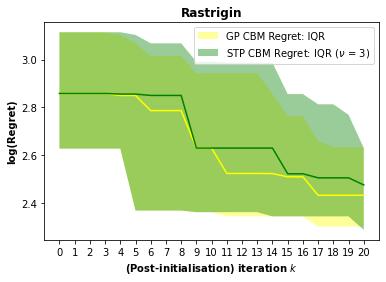

In [95]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'yellow')
plt.plot(median_stp, color = 'green')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'yellow', alpha=0.4, label='GP CBM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'green', alpha=0.4, label='STP CBM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!
